In [14]:
import pickle5 as pickle
from data_lp import LPDataset,get_image_transform
from vocab import Vocabulary
import json
import torch
from tqdm import tqdm
import pdb
import torchvision.transforms as transforms
from transformers import AutoTokenizer, BertModel, AutoModelForQuestionAnswering, BertTokenizerFast


def default_collate_fn(data, caption_lim = 512):
  # Sort a data list by sentence length
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, spoken_target, ocr_target, index, img_ids = zip(*data)
    # Merge images (convert tuple of 3D tensor to 4D tensor)
    images = torch.stack(images, 0)

    cap_lengths = torch.tensor([len(cap) if len(cap) <= caption_lim else caption_lim for cap in spoken_target])
    spoken_output = torch.zeros(len(spoken_target), caption_lim).long()
    

    for i, cap in enumerate(spoken_target):
      end = cap_lengths[i]
      if end <= caption_lim:
        spoken_output[i, :end] = cap[:end]
      else:
        cap_lengths[i] = caption_lim
        spoken_output[i, :end] = cap[:caption_lim]
    return images, spoken_output, ocr_target, cap_lengths, index, img_ids



def get_image_transform_default():
  t_list = []

  t_list = [transforms.Resize(256)]
  t_end = [transforms.ToTensor()]
  transform = transforms.Compose(t_list + t_end)
  return transform



In [29]:

#define speaker
sp = 'anat-1'

#define where data is downloaded - this is the zip file that you download 
root_data_dir = '/projects/dataset_processed/dongwonl/data/'
sp_data_dir = '{}/{}'.format(root_data_dir, sp)

#define where the training script with data_lp.py is in
src_dr = '/work/dongwonl/lecture_project/kumon'

#define where the vocab folder is in 
target_vocab_path = './vocab/%s_vocab.pkl' % sp
vocab = pickle.load(open(target_vocab_path, 'rb'))

#read jsons 
with open("{}/{}/{}_figs.json".format(root_data_dir, sp,sp), 'r') as f:
 fig_json = json.loads(f.read())

with open("{}/{}/{}.json".format(root_data_dir, sp,sp), 'r') as j:
 cap_json = json.loads(j.read())

with open("{}/{}/{}_capfig.json".format(root_data_dir, sp,sp), 'r') as c:
 connect_json = json.loads(c.read())

#load data
transform = get_image_transform_default() #use get_image_transform() for normalization + cropping + resizing
wemb_type = 'bert'
dataset = LPDataset(cap_json, fig_json, connect_json, vocab, sp_data_dir, wemb_type, transform)
loader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=1,
                                        shuffle=True,
                                        pin_memory=True,
                                        num_workers=1,
                                        collate_fn = default_collate_fn
                                        )

In [30]:
'''
Each sample constitues of 

images: normalized images of figures (3 x 224 x 224)
spoken_output: word tokens for spoken language (glove or bert)
ocr_target: word tokens for ocr on-slide text (glove or bert)
cap_lengths: length of captions
index: number image ids
img_ids: string image ids

'''

for itr, data in enumerate(tqdm(loader)):
    images, spoken_output, ocr_target, cap_lengths, index, img_ids = data
    break #break to show one sample
    
    



  0%|          | 0/590 [00:00<?, ?it/s]

# One Sample Example

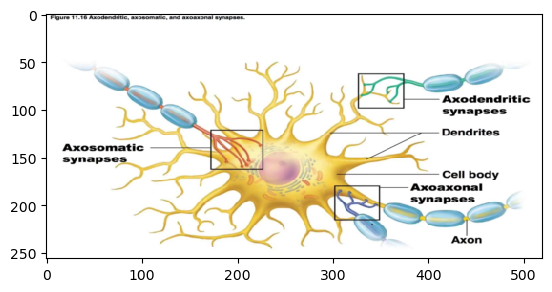

In [31]:
#images (transform not applied)

import matplotlib.pyplot as plt

plt.imshow(images[0].permute(1,2,0).numpy(), interpolation='nearest')
plt.show()

In [32]:
#example of spoken_output 

bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_tokenizer.decode(spoken_output[0], skip_special_tokens = True)

"in this image over here you can see in acts of dendritic acts of somatic and the actual axonal synapse so over here here's the axon of one neuron and we of the cell body of another so it's going to be the axial somatic and over here we have the axon of one neuron and the dendrites of another so this is the axle tend riddick and then here's again another axon of one neuron and we have the axon of another neuron so we have exo axonal synapse okay between the two exons"

In [36]:
#example of OCR 

bert_tokenizer.decode(ocr_target[0][0], skip_special_tokens = True)


'figure and axoaxonal axodendritic synapses dendrites axosomatic synapses cell body axoaxonal synapses axon'